In [1]:
import xarray as xr

import numpy as np
import pandas as pd
from pathlib import Path

import os, sys
import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as tkr
#import seaborn as sns
#sns.set_style('ticks')

from scipy import stats
from scipy.stats import percentileofscore

from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
#from sklearn.datasets import fetch_california_housing

In [28]:
def multilin(X,y,scale=0,trainportion=0.67):
    X_train, X_test= np.split(X, [int(trainportion *len(X))])
    y_train, y_test= np.split(y, [int(trainportion *len(X))])
    model = LinearRegression()
    if scale ==1:
        scaler1 = StandardScaler().set_output(transform="pandas")
        #scaled_X_train = scaler1.fit_transform(X_train)
        scaler1_model=scaler1.fit(X_train)
        scaled_X_train = scaler1_model.transform(X_train)
        model.fit(scaled_X_train, y_train)
        #scaled_X_test = scaler1.fit_transform(X_test)
        scaled_X_test = scaler1_model.transform(X_test)
        y_pred = model.predict(scaled_X_test)
        y_pred_train=model.predict(scaled_X_train)
    elif scale==2:
        scaler2 = MinMaxScaler().set_output(transform="pandas")
        scaler2_model = scaler2.fit(X_train) #use the statistics of the training data to scale the testing data later
        scaled_X_train=scaler2_model.transform(X_train)
        model.fit(scaled_X_train, y_train)
        scaled_X_test = scaler2_model.transform(X_test)
        y_pred = model.predict(scaled_X_test)
        y_pred_train=model.predict(scaled_X_train)
    
    elif scale==0:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_train=model.predict(X_train)
    
    #Not appropriate to scale the data using information from the testing period
    # model = LinearRegression()
    # y_train, y_test= np.split(y, [int(.67 *len(X))])
    # if scale ==1:
    #     scaler1 = StandardScaler().set_output(transform="pandas")
    #     scaled_X1=scaler1.fit_transform(X)
    #     X_train, X_test= np.split(scaled_X1, [int(.67 *len(X))])     
    # elif scale==2:
    #     scaler2 = MinMaxScaler().set_output(transform="pandas")
    #     scaled_X2=scaler2.fit_transform(X)
    #     X_train, X_test= np.split(scaled_X2, [int(.67 *len(X))]) 
    # else:
    #     X_train, X_test= np.split(X, [int(.67 *len(X))]) 

    # model.fit(X_train, y_train)
    # y_pred_train=model.predict(X_train)
    # y_pred = model.predict(X_test)

    a={
    "Variable":[str(i) for i in X.keys()],
    "Coeffcient":np.array(model.coef_)
    }
    coeff_df=pd.DataFrame(a)
    print(coeff_df)
    
    y_test_plot=y_test.reset_index() #so when I plot they appear on top of eachother
    fig = plt.figure(figsize=(20,6))
    mpl.rcParams.update({'font.size': 22})
    ax = plt.gca()
    ax.plot(X_test.index,y_test_plot.Residual,label='observation')
    ax.plot(X_test.index, y_pred,label='model prediction')
    ax.set_ylabel("Non-Tidal Residual [m]")
    #ax.set_xticks(X_test.index)
    #ax.xaxis.set_major_formatter(X.time.DateFormatter('%b-%Y'))
    ax.legend(loc="upper right")

    #add R2 of the training
    print('R2 Train = '+str(r2_score(y_train,y_pred_train)))
    print('R2 Test = '+str(r2_score(y_test,y_pred)))
    print('MSE = '+str(mean_squared_error(y_test, y_pred)))
    print('MAE = '+str(mean_absolute_error(y_test, y_pred)))

Do an initial test of the multilinear regression for non tidal residuals for Monterey bay 

The compiled csv is created in /global/scratch/users/jennaisrael/climate_data_processing/sl_regression/compile_regression_data.ipynb

# Read in the data

In [3]:
df_m=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/sl_regression/monterey.regression.data.hourly.1996.2020.csv",parse_dates=['time']).set_index(['time'])
#the variable "Residual" is what we want it is calculated by subtracting from utide predicted tide, see notebook global
#/scratch/users/jennaisrael/climate_data_processing/sl_regression/detrended_residuals_utide.ipynb
df_pr=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/sl_regression/point_reyes.regression.data.hourly.1996.2020.csv",parse_dates=['time']).set_index(['time'])
df_m

,u10_stress_a,v10_stress_a,msl_a,sst_a,PDO_a,EN3.4_a,Residual
time,,,,,,,
1995-12-31 16:00:00,8.956125,-43.981939,736.900563,0.659997,0.836933,-1.306148,-0.041708
1995-12-31 17:00:00,5.255560,-33.640463,771.835528,0.659997,0.836933,-1.306148,-0.049622
1995-12-31 18:00:00,4.653470,-29.136661,734.585493,0.659997,0.836933,-1.306148,-0.050717
1995-12-31 19:00:00,7.100264,-24.445409,689.835457,0.659997,0.836933,-1.306148,-0.043857
1995-12-31 20:00:00,15.985210,-32.178663,623.085422,0.659997,0.836933,-1.306148,-0.056559
...,...,...,...,...,...,...,...
2021-10-01 19:00:00,-1.437500,0.301881,-145.706222,1.620365,-2.707063,-1.352207,-0.005646
2021-10-01 20:00:00,1.117509,-0.157175,-153.396257,1.620364,-2.707063,-1.352207,-0.015753
2021-10-01 21:00:00,1.308850,0.070465,-179.146292,1.620364,-2.707063,-1.352207,-0.019239


              u10_stress_a  v10_stress_a     msl_a     sst_a     PDO_a  \
u10_stress_a      1.000000     -0.592899 -0.043438 -0.109066 -0.015966   
v10_stress_a     -0.592899      1.000000 -0.235925  0.069243  0.042988   
msl_a            -0.043438     -0.235925  1.000000 -0.227528 -0.028069   
sst_a            -0.109066      0.069243 -0.227528  1.000000  0.192847   
PDO_a            -0.015966      0.042988 -0.028069  0.192847  1.000000   
EN3.4_a           0.108742     -0.047325 -0.159477  0.079948  0.545245   
Residual         -0.143404      0.407406 -0.586303  0.314171  0.385934   

               EN3.4_a  Residual  
u10_stress_a  0.108742 -0.143404  
v10_stress_a -0.047325  0.407406  
msl_a        -0.159477 -0.586303  
sst_a         0.079948  0.314171  
PDO_a         0.545245  0.385934  
EN3.4_a       1.000000  0.413435  
Residual      0.413435  1.000000  


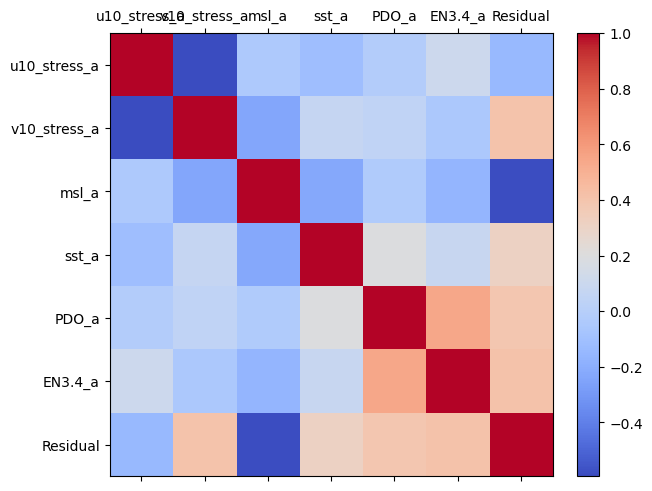

In [4]:
matrix = df_m.corr()
print(matrix)
fig, ax =plt.subplots(layout="constrained")
a=ax.matshow(matrix,cmap="coolwarm")
ax.set_xticks(range(len(matrix.columns)), matrix.columns)
ax.set_yticks(range(len(matrix.columns)), matrix.columns)
fig.colorbar(a,ax=ax)
plt.show()

              u10_stress_a  v10_stress_a     msl_a     sst_a     PDO_a  \
u10_stress_a      1.000000     -0.811172 -0.150853 -0.259470 -0.041475   
v10_stress_a     -0.811172      1.000000 -0.032683  0.246159  0.050278   
msl_a            -0.150853     -0.032683  1.000000 -0.126567 -0.032894   
sst_a            -0.259470      0.246159 -0.126567  1.000000  0.328570   
PDO_a            -0.041475      0.050278 -0.032894  0.328570  1.000000   
EN3.4_a           0.146708     -0.104457 -0.164457  0.091571  0.545245   
Residual         -0.329635      0.470612 -0.597028  0.345137  0.323111   

               EN3.4_a  Residual  
u10_stress_a  0.146708 -0.329635  
v10_stress_a -0.104457  0.470612  
msl_a        -0.164457 -0.597028  
sst_a         0.091571  0.345137  
PDO_a         0.545245  0.323111  
EN3.4_a       1.000000  0.332799  
Residual      0.332799  1.000000  


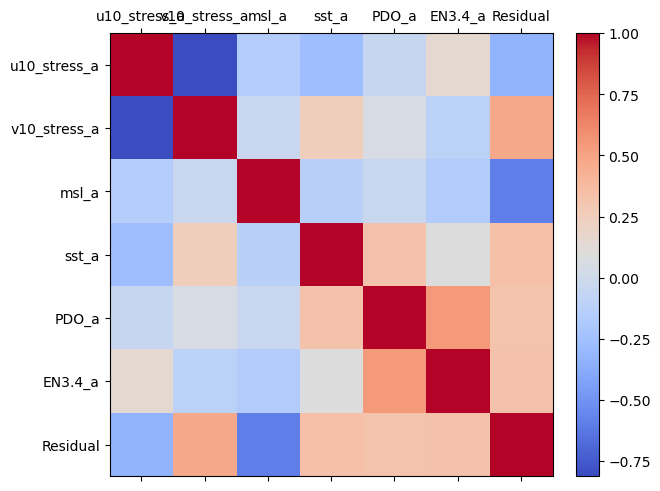

In [5]:
matrix_pr = df_pr.corr()
print(matrix_pr)
fig, ax =plt.subplots(layout="constrained")
a=ax.matshow(matrix_pr,cmap="coolwarm")
ax.set_xticks(range(len(matrix_pr.columns)), matrix_pr.columns)
ax.set_yticks(range(len(matrix_pr.columns)), matrix_pr.columns)
fig.colorbar(a,ax=ax)
plt.show()

In [30]:
#drop the nan first
df_m_clean=df_m.dropna()

In [31]:
X = df_m_clean[["u10_stress_a","v10_stress_a","msl_a","sst_a","PDO_a","EN3.4_a"]] #also leave date out for now
y = df_m_clean["Residual"]
X

,u10_stress_a,v10_stress_a,msl_a,sst_a,PDO_a,EN3.4_a
time,,,,,,
1995-12-31 16:00:00,8.956125,-43.981939,736.900563,0.659997,0.836933,-1.306148
1995-12-31 17:00:00,5.255560,-33.640463,771.835528,0.659997,0.836933,-1.306148
1995-12-31 18:00:00,4.653470,-29.136661,734.585493,0.659997,0.836933,-1.306148
1995-12-31 19:00:00,7.100264,-24.445409,689.835457,0.659997,0.836933,-1.306148
1995-12-31 20:00:00,15.985210,-32.178663,623.085422,0.659997,0.836933,-1.306148
...,...,...,...,...,...,...
2021-10-01 19:00:00,-1.437500,0.301881,-145.706222,1.620365,-2.707063,-1.352207
2021-10-01 20:00:00,1.117509,-0.157175,-153.396257,1.620364,-2.707063,-1.352207
2021-10-01 21:00:00,1.308850,0.070465,-179.146292,1.620364,-2.707063,-1.352207


/global/home/users/jennaisrael/.conda/envs/geoplot/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/global/home/users/jennaisrael/.conda/envs/geoplot/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


       Variable    Coeffcient
0  u10_stress_a  2.526477e-07
1  v10_stress_a  7.884429e-04
2         msl_a -7.516457e-05
3         sst_a  6.254515e-03
4         PDO_a  1.404659e-02
5       EN3.4_a  1.635743e-02
R2 Train = 0.5991256894085746
R2 Test = 0.5651322811243191
MSE = 0.0018427859040216297
MAE = 0.034066375549101406


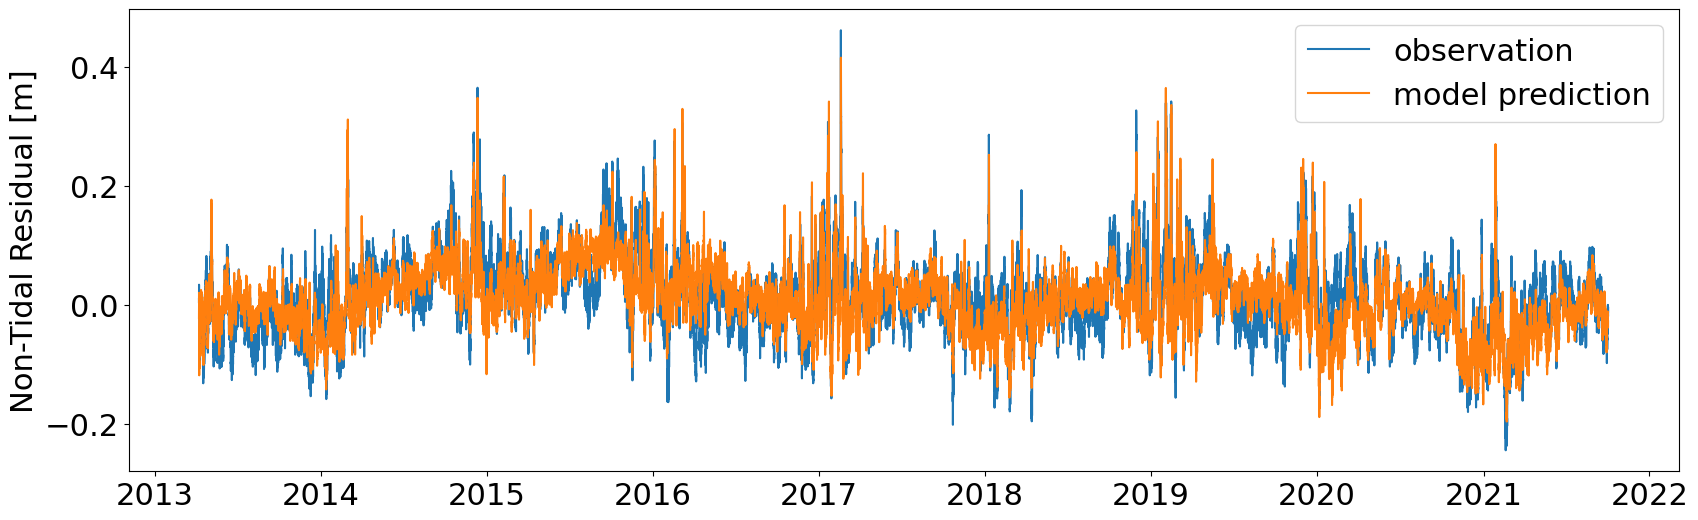

In [32]:
multilin(X,y)

/global/home/users/jennaisrael/.conda/envs/geoplot/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/global/home/users/jennaisrael/.conda/envs/geoplot/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


       Variable  Coeffcient
0  u10_stress_a    0.000004
1  v10_stress_a    0.021963
2         msl_a   -0.033722
3         sst_a    0.008446
4         PDO_a    0.016016
5       EN3.4_a    0.016684
R2 Train = 0.5991256894085747
R2 Test = 0.5651322811243222
MSE = 0.0018427859040216171
MAE = 0.034066375549101226


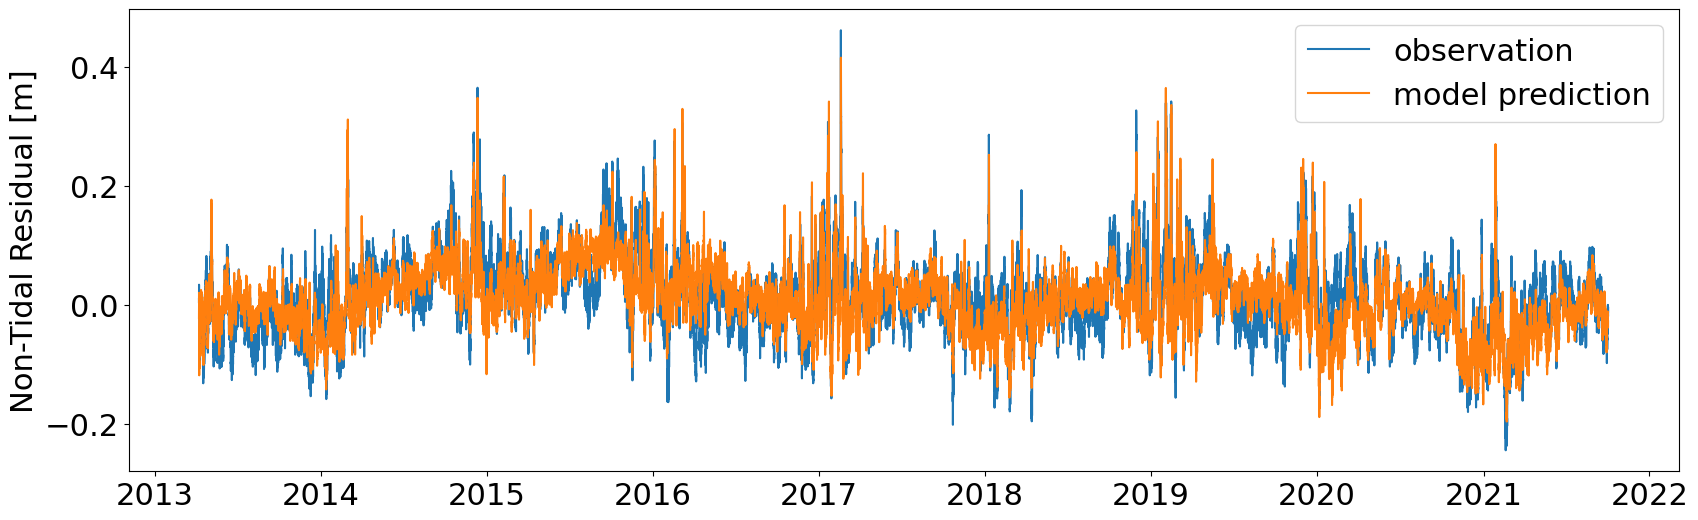

In [37]:
multilin(X,y,scale=1,trainportion=0.67)

/global/home/users/jennaisrael/.conda/envs/geoplot/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/global/home/users/jennaisrael/.conda/envs/geoplot/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


       Variable  Coeffcient
0  u10_stress_a    0.000096
1  v10_stress_a    0.490900
2         msl_a   -0.428770
3         sst_a    0.052250
4         PDO_a    0.077602
5       EN3.4_a    0.071219
R2 Train = 0.5991256894085747
R2 Test = 0.5651322811243222
MSE = 0.0018427859040216171
MAE = 0.034066375549101226


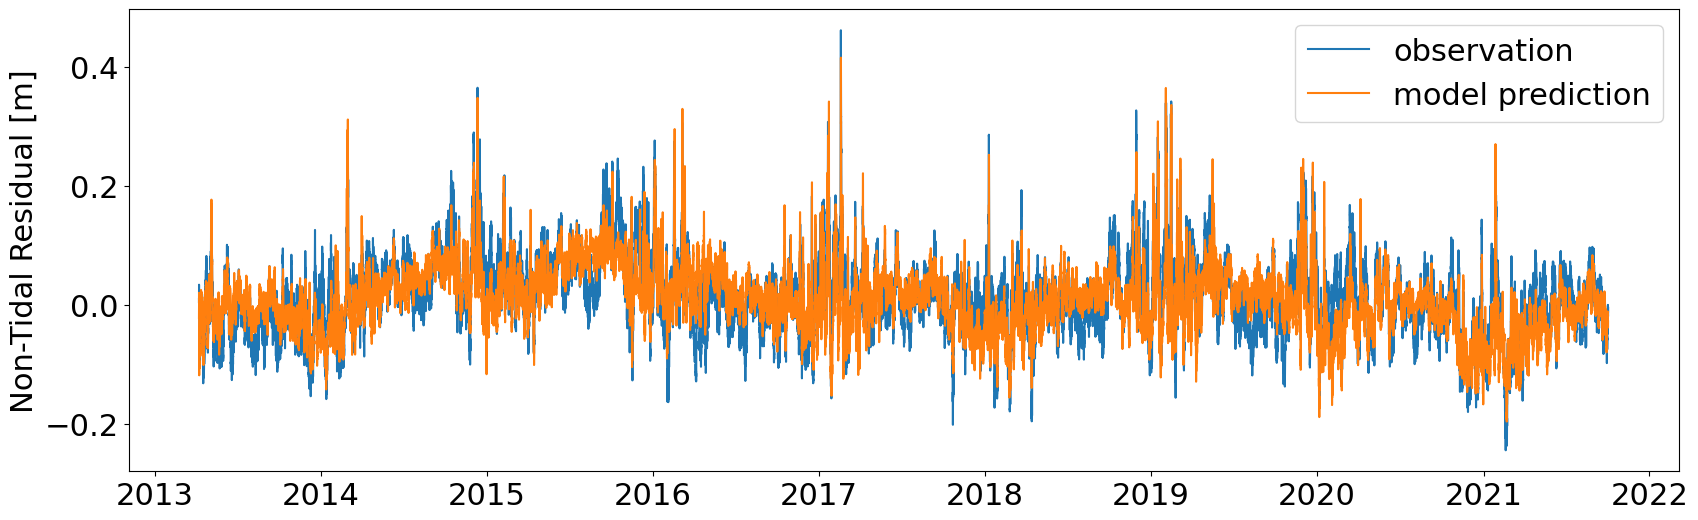

In [34]:
multilin(X,y,scale=2)

In [ ]:
X_train, X_test= np.split(X, [int(.67 *len(X))])
y_train, y_test= np.split(y, [int(.67 *len(X))])

In [ ]:
model = LinearRegression()

model.fit(X_train, y_train)

In [ ]:
print(model.coef_)
print(model.intercept_)

In [ ]:
a={
    "Variable":[str(i) for i in X.keys()],
    "Coeffcient":np.array(model.coef_)
}
hourly_m_me=pd.DataFrame(a)
hourly_m_me

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_test_plot=y_test.reset_index() #so when I plot they appear on top of eachother

fig, ax =plt.subplots()

ax.plot(y_test_plot.Residual,label='real data')
ax.plot(y_pred,label='model prediction')
fig.legend()

In [ ]:
#resample the whole dataframe and then drop na again

In [ ]:
df_m_daily_clean=df_m.resample("1D").mean().dropna()

In [ ]:
X = df_m_daily_clean[["u10_stress_a","v10_stress_a","msl_a","sst_a","PDO_a","EN3.4_a"]] #also leave date out for now
y = df_m_daily_clean["Residual"]
X

In [ ]:
multilin(X,y)

In [ ]:
multilin(X,y,scale=1)

In [ ]:
multilin(X,y,scale=2)

In [ ]:
X_train, X_test= np.split(X, [int(.67 *len(X))])
y_train, y_test= np.split(y, [int(.67 *len(X))])

In [ ]:
model = LinearRegression()

model.fit(X_train, y_train)

In [ ]:
print(model.coef_)
print(model.intercept_)

In [ ]:
a={
    "Variable":[str(i) for i in X.keys()],
    "Coeffcient":np.array(model.coef_)
}
daily_m_me=pd.DataFrame(a)
daily_m_me

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print(r2_score(y_test,y_pred))
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

In [ ]:
y_test_plot=y_test.reset_index() #so when I plot they appear on top of eachother

fig, ax =plt.subplots()

ax.plot(y_test_plot.Residual,label='real data')
ax.plot(y_pred,label='model prediction')
fig.legend()

# Sam's Data

Variables we will use in the regression: sea-level pressure (PSL), windstress from u, windstress from v, ENSO index, PDO index, air temperature (if I can pick an on land location that is close enough, masked out for the ocean)

In [ ]:
#now compare with Sam's residuals
mb_sam=pd.read_fwf("/global/scratch/users/jennaisrael/time_varying_data/slr_data_sam/data4regrbuild.daily.era5.monterey.norm0.txt")
mb_sam.columns=["Year", "Month", "Day", "ResWL_lo", "ResWL_hi", "SLPa", "TASa", "N34a", "PDOa", "U10a", "V10a"]
mb_sam["date"]=pd.to_datetime(mb_sam[['Year', 'Month', 'Day']])
#datetime seems to be causing an issue leave it from the index for now
mb_sam.index=mb_sam["date"]
mb_sam["Residual"]=mb_sam["ResWL_hi"]+mb_sam["ResWL_lo"]
mb_sam

In [ ]:
matrix = mb_sam[["SLPa","TASa","N34a","U10a","V10a","PDOa","Residual"]].corr()
print(matrix)
fig, ax =plt.subplots(layout="constrained")
a=ax.matshow(matrix,cmap="coolwarm")
ax.set_xticks(range(len(matrix.columns)), matrix.columns)
ax.set_yticks(range(len(matrix.columns)), matrix.columns)
fig.colorbar(a,ax=ax)
plt.show()

# Difference between with all variables, no pdo, no u, and no u and no pdo

In [4]:
#drop the nan first
df_m_clean=df_m.dropna()
X_all = df_m_clean[["u10_stress_a","v10_stress_a","msl_a","sst_a","PDO_a","EN3.4_a"]] #also leave date out for now
X_nopdo = df_m_clean[["u10_stress_a","v10_stress_a","msl_a","sst_a","EN3.4_a"]]
X_nou10 = df_m_clean[["u10_stress_a","v10_stress_a","msl_a","sst_a","PDO_a","EN3.4_a"]]
X_nopdou10 = df_m_clean[["v10_stress_a","msl_a","sst_a","EN3.4_a"]]
y = df_m_clean["Residual"]

In [ ]:
multilin(X_all,y,scale=1)

In [ ]:
multilin(X_nopdo,y,scale=1)

In [ ]:
multilin(X_nou10,y,scale=1)

In [ ]:
multilin(X_nopdou10,y,scale=1)

# Does it improve the daily downsample?

In [8]:
df_m_daily_clean=df_m.resample("1D").mean().dropna()
X_all = df_m_daily_clean[["u10_stress_a","v10_stress_a","msl_a","sst_a","PDO_a","EN3.4_a"]] #also leave date out for now
X_nopdo = df_m_daily_clean[["u10_stress_a","v10_stress_a","msl_a","sst_a","EN3.4_a"]]
X_nou10 = df_m_daily_clean[["u10_stress_a","v10_stress_a","msl_a","sst_a","PDO_a","EN3.4_a"]]
X_nopdou10 = df_m_daily_clean[["v10_stress_a","msl_a","sst_a","EN3.4_a"]]
y = df_m_daily_clean["Residual"]

In [5]:
X_all.index

DatetimeIndex(['1995-12-31', '1996-01-01', '1996-01-02', '1996-01-03',
               '1996-01-04', '1996-01-05', '1996-01-06', '1996-01-07',
               '1996-01-08', '1996-01-09',
               ...
               '2021-09-22', '2021-09-23', '2021-09-24', '2021-09-25',
               '2021-09-26', '2021-09-27', '2021-09-28', '2021-09-29',
               '2021-09-30', '2021-10-01'],
              dtype='datetime64[ns]', name='time', length=9393, freq=None)

/global/home/users/jennaisrael/.conda/envs/geoplot/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/global/home/users/jennaisrael/.conda/envs/geoplot/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


       Variable  Coeffcient
0  u10_stress_a    0.000760
1  v10_stress_a    0.025012
2         msl_a   -0.031891
3         sst_a    0.008169
4         PDO_a    0.015269
5       EN3.4_a    0.017447
R2 Train = 0.64460254280966
R2 Test = 0.4959153198336905
MSE = 0.0020024303214295483
MAE = 0.0354005615927701


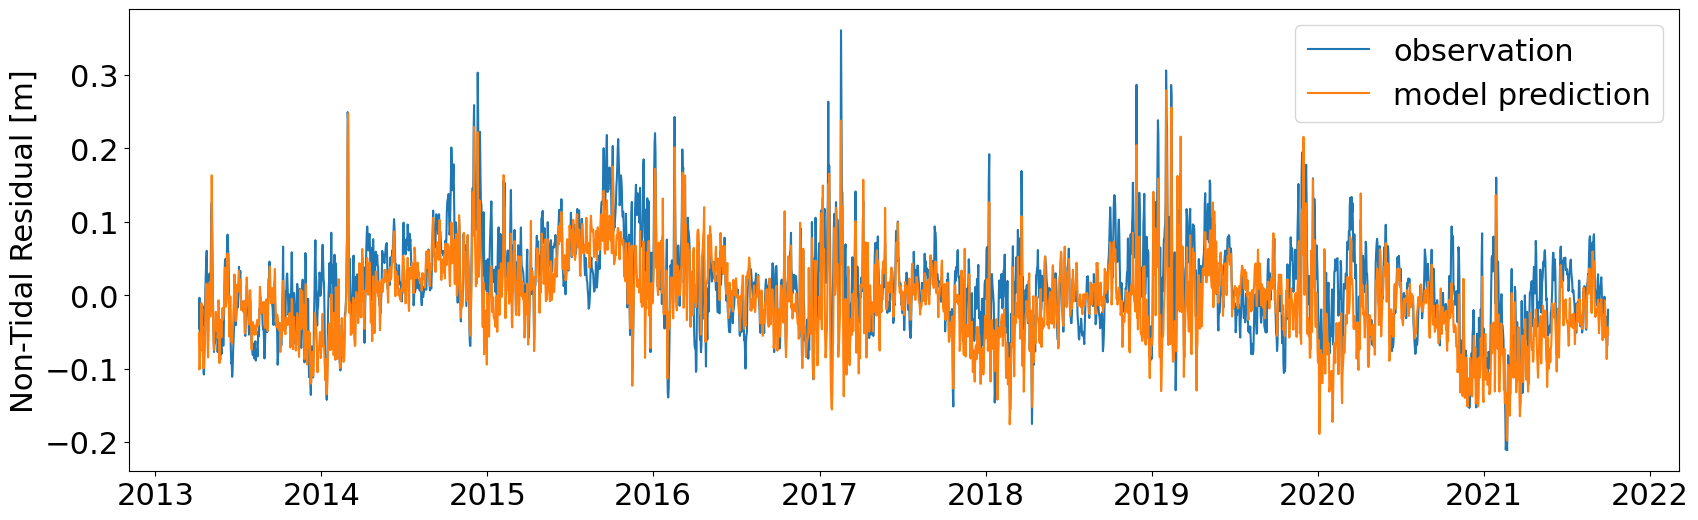

In [19]:
multilin(X_all,y,scale=1)

/global/home/users/jennaisrael/.conda/envs/geoplot/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/global/home/users/jennaisrael/.conda/envs/geoplot/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


       Variable  Coeffcient
0  u10_stress_a    0.000324
1  v10_stress_a    0.024085
2         msl_a   -0.031160
3         sst_a    0.009591
4         PDO_a    0.016489
5       EN3.4_a    0.017949
R2 Train = 0.6546851894143315
R2 Test = 0.5418462468303651
MSE = 0.0016362962918528192
MAE = 0.03243122767938678


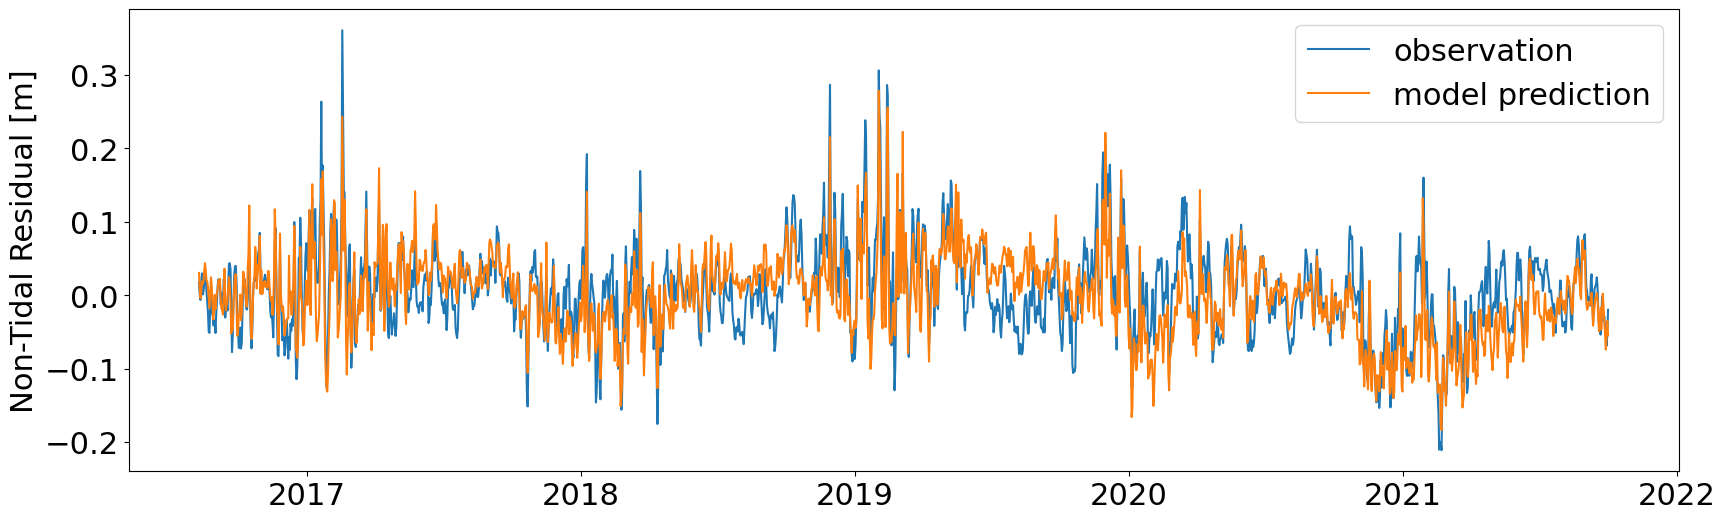

In [21]:
multilin(X_all,y,scale=1,trainportion=0.8)

/global/home/users/jennaisrael/.conda/envs/geoplot/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/global/home/users/jennaisrael/.conda/envs/geoplot/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


       Variable  Coeffcient
0  u10_stress_a    0.004904
1  v10_stress_a    0.359828
2         msl_a   -0.328567
3         sst_a    0.055978
4         PDO_a    0.076578
5       EN3.4_a    0.077342
R2 Train = 0.6546851894143315
R2 Test = 0.5765691447898038
MSE = 0.0015122834494820257
MAE = 0.030954616312778564


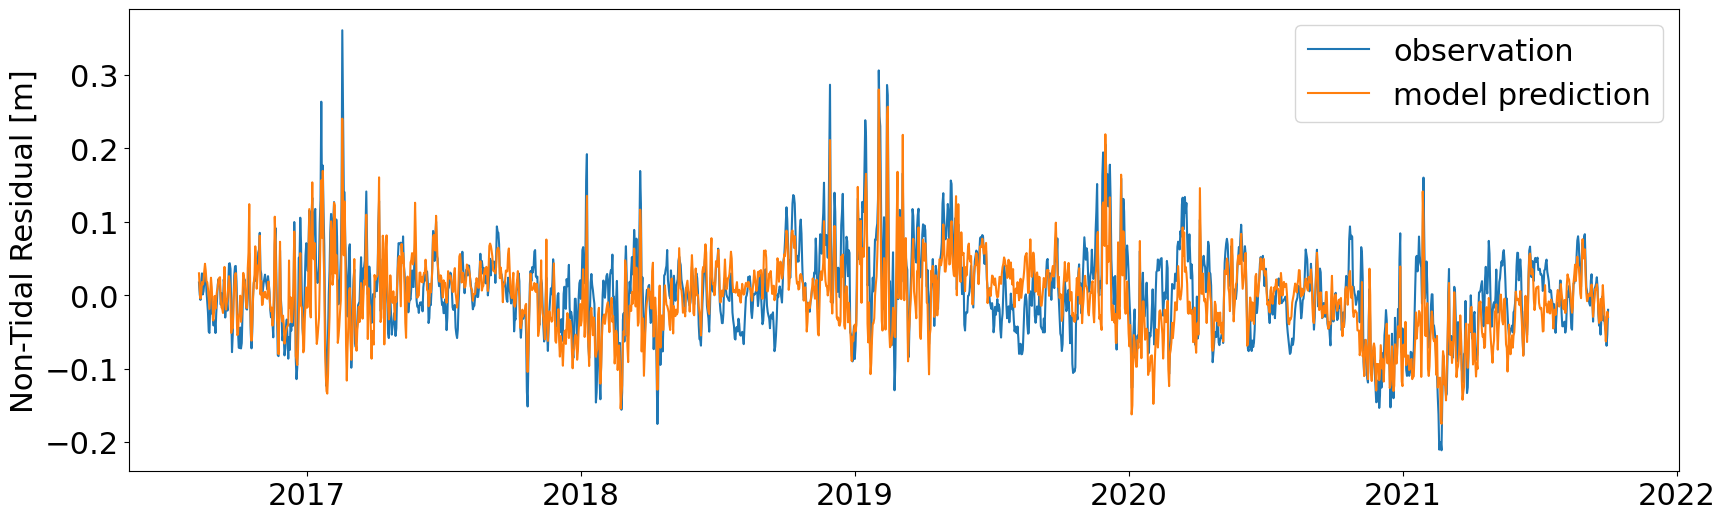

In [27]:
multilin(X_all,y,scale=2,trainportion=0.8)

In [ ]:
multilin(X_nopdo,y,scale=1)

In [ ]:
multilin(X_nou10,y,scale=1)

In [ ]:
multilin(X_nopdou10,y,scale=1)

# For Sam's data

In [ ]:
X_all = mb_sam[["SLPa","TASa","N34a","PDOa","U10a","V10a"]]
X_nopdo = mb_sam[["SLPa","TASa","N34a","U10a","V10a"]]
X_nou10 = mb_sam[["SLPa","TASa","N34a","PDOa","V10a"]]
X_nopdou10 = mb_sam[["SLPa","TASa","N34a","V10a"]]
y = mb_sam["Residual"]

In [ ]:
multilin(X_all,y,scale=1)

In [ ]:
multilin(X_nopdo,y,scale=1)

In [ ]:
multilin(X_nou10,y,scale=1)

In [ ]:
multilin(X_nopdou10,y,scale=1)

# Compare the independent variables for my and Sam's data

In [ ]:
fig, ax = plt.subplots(3,2, sharex=True,layout="constrained")
ax[0,0].plot(mb_sam.SLPa,label='Sam SLP anomaly')
ax[0,0].plot(df_m.msl_a*0.01,label='My msl anomaly')
ax[0,0].set_title("Pressure anomaly")

ax[0,1].plot(mb_sam.TASa,label='Sam TAS anomaly')
ax[0,1].plot(df_m.sst_a,label='My sst anomaly')
ax[0,1].set_title("Temperature anomaly")

ax[1,0].plot(mb_sam.N34a,label='Sam N34 anomaly')
ax[1,0].plot(df_m["EN3.4_a"],label='My EN3.4 anomaly')
ax[1,0].set_title("EN3.4 anomaly")

ax[1,1].plot(mb_sam.PDOa,label='Sam PDO anomaly')
ax[1,1].plot(df_m["PDO_a"],label='My PDO anomaly')
ax[1,1].set_title("PDO anomaly")

ax[2,0].plot(mb_sam.U10a,label='Sam u stress anomaly')
ax[2,0].plot(df_m["u10_stress_a"],label='My u stress anomaly')
ax[2,0].set_title("U stress anomaly")

ax[2,1].plot(mb_sam.V10a,label='Sam v stress anomaly')
ax[2,1].plot(df_m["v10_stress_a"],label='My v stress anomaly')
ax[2,1].set_title("V stress anomaly")

ax[0,0].set_xlim(datetime(1995,12,31),datetime(2021,10,21))

In [ ]:
fig, ax = plt.subplots(3,2, sharex=True,layout="constrained")
ax[0,0].plot(mb_sam.SLPa,label='Sam SLP anomaly')
ax[0,0].plot(df_m_daily_clean.msl_a*0.01,label='My msl anomaly')
ax[0,0].set_title("Pressure anomaly")

ax[0,1].plot(mb_sam.TASa,label='Sam TAS anomaly')
ax[0,1].plot(df_m_daily_clean.sst_a,label='My sst anomaly')
ax[0,1].set_title("Temperature anomaly")

ax[1,0].plot(mb_sam.N34a,label='Sam N34 anomaly')
ax[1,0].plot(df_m_daily_clean["EN3.4_a"],label='My EN3.4 anomaly')
ax[1,0].set_title("EN3.4 anomaly")

ax[1,1].plot(mb_sam.PDOa,label='Sam PDO anomaly')
ax[1,1].plot(df_m_daily_clean["PDO_a"],label='My PDO anomaly')
ax[1,1].set_title("PDO anomaly")

ax[2,0].plot(mb_sam.U10a,label='Sam u stress anomaly')
ax[2,0].plot(df_m_daily_clean["u10_stress_a"],label='My u stress anomaly')
ax[2,0].set_title("U stress anomaly")

ax[2,1].plot(mb_sam.V10a,label='Sam v stress anomaly')
ax[2,1].plot(df_m_daily_clean["v10_stress_a"],label='My v stress anomaly')
ax[2,1].set_title("V stress anomaly")

ax[0,0].set_xlim(datetime(1995,12,31),datetime(2021,10,21))

In [ ]:
#zoom in on the pressure anomaly
fig, ax = plt.subplots(2,sharex=True,layout="constrained")
ax[0].plot(mb_sam.SLPa,label='Sam SLP anomaly')
ax[0].plot(df_m_daily_clean.msl_a*0.01,label='My msl anomaly')
ax[0].set_title("Pressure anomaly")

ax[1].plot(mb_sam.TASa,label='Sam TAS anomaly')
ax[1].plot(df_m_daily_clean.sst_a,label='My sst anomaly')
ax[1].set_title("Temperature anomaly")

ax[1].set_xlim(datetime(1995,12,31),datetime(1996,12,21))
ax[0].legend()
ax[1].legend()

In [ ]:
#look at the downsampled
fig, ax = plt.subplots(sharex=True,layout="constrained")
ax.plot(mb_sam.Residual,label='Sam NTR')
ax.plot(df_m_daily_clean.Residual,label='My daily NTR')
ax.set_title("NTR")
ax.set_xlim(datetime(1995,12,31),datetime(2021,10,21))
fig.legend()

Make a new dataframe replacing Sam's residual with mine, trimming to have the same start and end date 
This also requires resampling my residuals to be daily (ultimately they should be hourly)


for now just practice setting up the multilinear regression and doing train test split

In [ ]:
X = mb_sam[["SLPa","TASa","N34a","U10a","V10a"]] #also leave date out for now
y = mb_sam["Residual"]

In [ ]:
multilin(X,y)

In [ ]:
multilin(X,y,scale=1)

In [ ]:
multilin(X,y,scale=2)

In [ ]:
multilin(X,y,scale=1)

In [ ]:
X

Try a simple single chronological train test split for now

In [ ]:
X_train, X_test= np.split(X, [int(.67 *len(X))])
y_train, y_test= np.split(y, [int(.67 *len(X))])

In [ ]:
model = LinearRegression()

model.fit(X_train, y_train)

In [ ]:
print(model.coef_)
print(model.intercept_)

In [ ]:
vars=[str(i) for i in X.keys()]
vars

In [ ]:
a={
    "Variable":[str(i) for i in X.keys()],
    "Coeffcient":np.array(model.coef_)
}
daily_m_sam=pd.DataFrame(a)
daily_m_sam

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_test_plot

In [ ]:
y_test_plot=y_test.reset_index() #so when I plot they appear on top of eachother

fig, ax =plt.subplots()

ax.plot(y_test_plot.ResWL_total,label='real data')
ax.plot(y_pred,label='model prediction')
fig.legend()

In [ ]:
r2_score(y_test,y_pred)

In [ ]:
mean_squared_error(y_test, y_pred)

In [ ]:
mean_absolute_error(y_test, y_pred)

In [ ]:
test=xr.open_dataset("/global/scratch/users/jennaisrael/time_varying_data/test_cirrus/noaa_stdmet_46012_1996.nc")
test

test data seems to be from a buoy in the pacific ocean https://www.ndbc.noaa.gov/station_page.php?station=46012, could be good for windstress?